In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Credentials
DB_NAME = 'documentcoder'
DB_USER = 'postgres'
DB_PASS = 'save'

In [33]:
# CONNECTION IS ESTABLISHED IF NOTHING RETURNS 
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS)

In [34]:
# Create Cursor to execute statements
cur = conn.cursor()

In [35]:
# Task at hand is to create a spreadsheet that has all the codings and all the questions 
# Plan to organize that: 
# retrieve a list of all the question id for specific policies like CCPA, GDPR, and so on 
#     To do so query: select for specific question id based on their labels: GDPR, CCPA, then store them in a dictionary
# then using that dictionary we can map coding instance answers to their associated question labels

In [36]:
cur.execute(
    "SELECT arr.item_object FROM api_coding, \
    jsonb_array_elements(categories) with ordinality arr(item_object, position)")

In [37]:
api_codings = cur.fetchall()

In [38]:
codings_dict = {}

for coding in api_codings: 
    #print('label: ', coding[0]['label'])
    label = coding[0]['label']
    ids = []
    for question in coding[0]['questions']:
        #print(question['id'])
        ids.append(question['id'])
        
    codings_dict[label] = ids
    
print(codings_dict)

{'CCPA': ['v72.1_2020.1', 'v72.2_2020.1', 'v73_2020.1', 'v74_2020.1', 'v75_2020.1', 'v76_2020.1', 'v77_2020', 'v78_2020.1', 'v72_2020.1', 'v80_2020.1'], 'Notice': ['v3_2020', 'v10.1_2020', 'v10.2_2020.1', 'v11.1_2020', 'v12_2020.1', 'v13_2020.1', 'v17_2020', 'v18_2020', 'v19_2020', 'v32_2020', 'v35_2020', 'v36_2020', 'v48_2020'], 'Sharing': ['v20_2020.1', 'v21_2020.1', 'v22_2020.1', 'v27_2020.1', 'v28_2020', 'v29_2020', 'v31_2020'], 'User Control': ['v37_2020', 'v38_2020.1', 'v37.2_2020.1', 'v39_2020', 'v40_2020.1', 'v47_2020.1', 'v49_2020', 'v51_2020'], 'Security': ['v41_2020', 'v42_2020', 'v43_2020', 'v44_2020', 'v45_2020', 'v46_2020', 'v53_2020', 'v54_2020'], 'Data Practices': ['v52_2020'], 'Enforcement': ['v55_2020', 'v56_2020', 'v57_2020', 'v58_2020', 'v59_2020', 'v60_2020', 'v61_2020', 'v62_2020.1'], 'Privacy By Design': ['v63_2020', 'v64_2020'], 'Contract': ['PP_in_TOU'], 'GDPR': ['v71_2020.1', 'v80.2_2020.1', 'v80.3_2020.1', 'v81_2020', 'v82_2020'], 'COVID': ['v83_2020'], '[Ski

In [39]:
def store_answer_freq(coding_instances):
    counter = defaultdict(int)
    for instance in coding_instances: 
        # checks to see if answer object has content or not, the second condition checks for empty objects 
        if (instance[0] is not None) and (bool(instance[0]) != False):
            counter[next(iter(instance[0]))] += 1
    
    #print(counter)
    return counter

In [40]:
def store_answer_conf(coding_instances):
    counter = defaultdict(int)
    for instance in coding_instances: 
        if (instance[1] is not None):
            counter[instance[1]] += 1
    
    #print(counter)
    return counter

In [41]:
def calc_median(conf_dict): 
    return np.median(list(conf_dict.values()))

In [42]:
def calc_avg_time(timing_arr): 
    return np.mean(np.array(timing_arr))

In [43]:
def did_mediate(response_arr): 
    none_filter = [item for item in response_arr if item[0]]

    if len(none_filter) == 0:
        return False
    else: 
        return True

In [44]:
# [0] = no
# [1] = yes
# [.] = n/a

answer_mappings = {}

for coding, q_ids in codings_dict.items(): 
    coding_answers_list = []
    for q_id in q_ids: 
        cur.execute("""
            SELECT coding_values->%s->'values', coding_values->%s->'confidence'
            FROM api_codinginstance;
            """,[q_id,q_id,])
        
        query_res = cur.fetchall()
        freqs = store_answer_freq(query_res)
        confs = store_answer_conf(query_res)
        median_conf = calc_median(confs)
        
        cur.execute("""
            SELECT question_timings->%s->'total_focus', question_timings->%s->'total_blur'
            FROM api_timingsession 
            WHERE coder_email != 'davidbstein@gmail.com';
            """,[q_id,q_id,])
        
        query_res = cur.fetchall()
        
        focus_res = [timing_inst for timing_inst in query_res if timing_inst[0]]
        blur_res = [timing_inst for timing_inst in query_res if timing_inst[1]]
        
        avg_focus = calc_avg_time(focus_res)
        avg_blur = calc_avg_time(blur_res)
        
        cur.execute("""
            SELECT coding_values->%s->'values'
            FROM api_codinginstance
            WHERE coder_email = 'florencia.m.wurgler@gmail.com'; 
        """,[q_id,])
        
        query_res = cur.fetchall()
        fmw = did_mediate(query_res)
        
        answer_stats = {'q_id': q_id,
                       'answer_freq': freqs,
                       'conf_freq': confs,
                       'median_conf': median_conf,
                       'avg_focus': avg_focus,
                       'avg_blur': avg_blur,
                       'FMW': fmw}
        
        coding_answers_list.append(answer_stats)
    
    answer_mappings[coding] = coding_answers_list
        

/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
# cur.close()
# conn.close()

In [46]:
print(answer_mappings)

{'CCPA': [{'q_id': 'v72.1_2020.1', 'answer_freq': defaultdict(<class 'int'>, {'1': 10, '0': 7, '.': 6}), 'conf_freq': defaultdict(<class 'int'>, {'5': 15, '3': 2, '4': 3}), 'median_conf': 3.0, 'avg_focus': 61490.75, 'avg_blur': 107836.27272727272, 'FMW': True}, {'q_id': 'v72.2_2020.1', 'answer_freq': defaultdict(<class 'int'>, {'0': 9, '1': 8, '.': 6}), 'conf_freq': defaultdict(<class 'int'>, {'4': 6, '5': 8, '2': 2, '3': 3}), 'median_conf': 4.5, 'avg_focus': 20135.12, 'avg_blur': 33876.5, 'FMW': True}, {'q_id': 'v73_2020.1', 'answer_freq': defaultdict(<class 'int'>, {'0': 11, '1': 5, '.': 6}), 'conf_freq': defaultdict(<class 'int'>, {'4': 11, '5': 5, '3': 2}), 'median_conf': 5.0, 'avg_focus': 29540.80769230769, 'avg_blur': 50947.63636363636, 'FMW': False}, {'q_id': 'v74_2020.1', 'answer_freq': defaultdict(<class 'int'>, {'1': 11, '0': 7, '.': 5}), 'conf_freq': defaultdict(<class 'int'>, {'5': 8, '4': 6, '2': 4, '3': 1}), 'median_conf': 5.0, 'avg_focus': 61401.07142857143, 'avg_blur': 

In [17]:
CCPA = answer_mappings['CCPA']
notice = answer_mappings['Notice']
sharing = answer_mappings['Sharing']
user_control = answer_mappings['User Control']
security = answer_mappings['Security']
data_practices = answer_mappings['Data Practices']
enforcement = answer_mappings['Enforcement']
privacy_by_design = answer_mappings['Privacy By Design']
contract = answer_mappings['Contract']
GDPR = answer_mappings['GDPR']
covid = answer_mappings['COVID']
notice_of_contract = answer_mappings['[Skip me!] Notice of Contract']

In [18]:
def create_coding_df(mapping):
    df_base = {'question_id': [], '0': [], '1': [], '2': [], 'n/a': [], 'DND': [], 
               'confidence_0': [], 'confidence_1': [], 'confidence_2': [], 'confidence_3': [], 
               'confidence_4': [], 'confidence_5': [], 'median_confidence': [], 
               'average_focus': [], 'average_blur': [], 'help_needed': []}
    
    df = pd.DataFrame(data=df_base)
    
    for i in range(0, len(mapping)): 
        row = {'question_id': mapping[i]['q_id'], '0': mapping[i]['answer_freq']['0'], 
               '1': mapping[i]['answer_freq']['1'], '2': mapping[i]['answer_freq']['2'],
               'n/a': mapping[i]['answer_freq']['.'], 'DND': mapping[i]['answer_freq']['DND'],
               'confidence_0': mapping[i]['conf_freq']['0'], 'confidence_1': mapping[i]['conf_freq']['1'], 
               'confidence_2': mapping[i]['conf_freq']['2'], 'confidence_3': mapping[i]['conf_freq']['3'], 
               'confidence_4': mapping[i]['conf_freq']['4'], 'confidence_5': mapping[i]['conf_freq']['5'], 
               'median_confidence': mapping[i]['median_conf'], 'average_focus': mapping[i]['avg_focus'], 
               'average_blur': mapping[i]['avg_blur'], 'help_needed': mapping[i]['help_needed']}
    
        df = df.append(row, ignore_index = True)
    
    return df

In [19]:
CCPA_df = create_coding_df(CCPA)
notice_df = create_coding_df(notice)
sharing_df = create_coding_df(sharing)
user_control_df = create_coding_df(user_control)
security_df = create_coding_df(security)
data_practices_df = create_coding_df(data_practices)
enforcement_df = create_coding_df(enforcement)
privacy_by_design_df = create_coding_df(privacy_by_design)
contract_df = create_coding_df(contract)
GDPR_df = create_coding_df(GDPR)
covid_df = create_coding_df(covid)
notice_of_contract_df = create_coding_df(notice_of_contract)

In [20]:
CCPA_df

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v72.1_2020.1,7.0,10.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,3.0,15.0,3.0,61490.750000,107836.272727,1.0
1,v72.2_2020.1,9.0,8.0,0.0,6.0,0.0,0.0,0.0,2.0,3.0,6.0,8.0,4.5,20135.120000,33876.500000,1.0
2,v73_2020.1,11.0,5.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,11.0,5.0,5.0,29540.807692,50947.636364,0.0
3,v74_2020.1,7.0,11.0,0.0,5.0,0.0,0.0,0.0,4.0,1.0,6.0,8.0,5.0,61401.071429,140621.500000,1.0
4,v75_2020.1,3.0,6.0,7.0,7.0,0.0,0.0,0.0,1.0,6.0,7.0,6.0,6.0,30470.440000,58490.875000,1.0
5,v76_2020.1,10.0,3.0,0.0,10.0,0.0,0.0,0.0,2.0,5.0,9.0,4.0,4.5,49799.125000,121197.250000,1.0
6,v77_2020,6.0,8.0,0.0,8.0,0.0,0.0,0.0,2.0,3.0,8.0,5.0,4.0,33873.729167,64326.714286,0.0
7,v78_2020.1,3.0,2.0,4.0,5.0,0.0,0.0,1.0,0.0,3.0,10.0,5.0,4.0,41480.120000,69353.875000,1.0
8,v72_2020.1,5.0,6.0,8.0,4.0,0.0,0.0,0.0,1.0,7.0,10.0,2.0,4.5,46922.500000,75116.000000,1.0
9,v80_2020.1,10.0,0.0,6.0,7.0,0.0,0.0,1.0,1.0,1.0,12.0,4.0,1.0,48291.020833,73434.392857,1.0


In [21]:
notice_df

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v3_2020,23.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,14.0,2.0,2.0,74934.216667,1.378302e+05,1.0
1,v10.1_2020,3.0,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,14.0,2.5,76618.400000,1.545473e+05,1.0
2,v10.2_2020.1,4.0,20.0,0.0,0.0,1.0,0.0,1.0,2.0,7.0,8.0,2.0,2.0,216914.109375,5.327739e+05,1.0
3,v11.1_2020,13.0,6.0,0.0,0.0,5.0,0.0,1.0,0.0,2.0,11.0,5.0,3.5,121942.896552,1.793327e+05,1.0
4,v12_2020.1,24.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,5.0,7.0,1.0,3.0,229723.531250,3.125396e+05,1.0
5,v13_2020.1,23.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,8.0,0.0,8.0,38491.129032,7.568717e+04,1.0
6,v17_2020,1.0,19.0,0.0,0.0,4.0,0.0,1.0,1.0,2.0,6.0,8.0,2.0,88646.750000,1.307813e+05,1.0
7,v18_2020,4.0,2.0,0.0,0.0,19.0,0.0,0.0,4.0,2.0,10.0,3.0,3.5,76580.838710,1.058142e+05,1.0
8,v19_2020,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,13.0,3.0,2.5,836409.017857,1.295379e+06,1.0
9,v32_2020,2.0,23.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,5.0,15.0,3.5,78346.964286,1.650095e+05,1.0


In [22]:
sharing_df

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v20_2020.1,7.0,9.0,0.0,0.0,8.0,0.0,0.0,1.0,5.0,11.0,3.0,4.0,89187.592593,115534.131579,1.0
1,v21_2020.1,4.0,10.0,0.0,0.0,9.0,0.0,1.0,1.0,4.0,9.0,2.0,2.0,200036.258621,306308.138889,1.0
2,v22_2020.1,14.0,4.0,0.0,0.0,4.0,0.0,1.0,2.0,6.0,6.0,3.0,3.0,38657.788462,59483.458333,1.0
3,v27_2020.1,3.0,0.0,0.0,0.0,20.0,0.0,0.0,1.0,5.0,12.0,0.0,5.0,21179.454545,39962.100000,1.0
4,v28_2020,4.0,5.0,0.0,1.0,13.0,0.0,1.0,2.0,6.0,9.0,0.0,4.0,47442.180000,81578.291667,1.0
5,v29_2020,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,2.0,2.0,25567.812500,50323.900000,1.0
6,v31_2020,15.0,4.0,1.0,3.0,0.0,0.0,0.0,5.0,4.0,9.0,0.0,5.0,72137.895833,91957.357143,1.0


In [23]:
user_control_df

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v37_2020,7.0,16.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,5.0,1.0,101507.291667,115319.200000,1.0
1,v38_2020.1,3.0,5.0,15.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,6.0,3.5,73787.540000,117401.041667,1.0
2,v37.2_2020.1,2.0,0.0,15.0,0.0,6.0,0.0,1.0,1.0,4.0,10.0,2.0,2.0,63547.300000,98186.250000,1.0
3,v39_2020,3.0,17.0,2.0,0.0,0.0,0.0,3.0,2.0,2.0,9.0,1.0,2.0,63373.000000,89914.500000,1.0
4,v40_2020.1,3.0,5.0,0.0,0.0,14.0,0.0,0.0,6.0,6.0,4.0,2.0,5.0,122577.312500,144235.472222,0.0
5,v47_2020.1,8.0,6.0,0.0,0.0,9.0,0.0,1.0,0.0,1.0,15.0,2.0,1.5,24962.940000,38629.750000,1.0
6,v49_2020,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,13.0,1.0,2.0,12626.708333,16205.333333,1.0
7,v51_2020,2.0,4.0,4.0,0.0,13.0,0.0,1.0,3.0,3.0,10.0,2.0,3.0,79366.739130,111405.100000,1.0


In [24]:
security_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v41_2020,20.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,8.0,5.0,18799.740000,19792.282609,1.0
1,v42_2020,17.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,12.0,1.0,2.5,57358.360000,96056.321429,1.0
2,v43_2020,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,9.5,146210.630435,278376.454545,1.0
3,v44_2020,0.0,22.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,13.0,5.0,22827.104167,48282.000000,0.0
4,v45_2020,18.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,12.0,2.0,2.5,23063.434783,35924.181818,1.0
5,v46_2020,22.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,3.0,3.0,22749.620000,37724.321429,1.0
6,v53_2020,14.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,11.0,3.0,3.0,154613.740000,420417.437500,1.0
7,v54_2020,6.0,16.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,7.0,6.0,4.5,33208.791667,49307.500000,1.0


In [25]:
data_practices_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v52_2020,18.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,11.0,1.0,3.5,38775.630435,80708.35,1.0


In [26]:
enforcement_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v55_2020,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,7.0,8.0,2.0,71382.113636,78229.000000,1.0
1,v56_2020,7.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,11.0,4.0,60318.750000,67899.433333,1.0
2,v57_2020,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,9.0,13691.818182,34890.000000,1.0
3,v58_2020,12.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,10.0,4.0,3.5,23538.750000,27144.041667,1.0
4,v59_2020,13.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,13.0,3.0,2.0,12595.863636,12437.964286,1.0
5,v60_2020,7.0,15.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,8.0,3.0,3.5,69833.416667,88949.000000,1.0
6,v61_2020,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,9.5,19014.000000,23656.764706,1.0
7,v62_2020.1,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,0.0,8.5,34044.068182,45313.392857,1.0


In [27]:
privacy_by_design_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v63_2020,15.0,7.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,11.0,1.0,2.0,34332.727273,57783.500000,1.0
1,v64_2020,22.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,13.0,0.0,4.0,19819.613636,23250.666667,1.0


In [28]:
contract_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,PP_in_TOU,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,9.5,55138.409091,81057.083333,1.0


In [29]:
GDPR_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v71_2020.1,13.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0,9.0,20180.386364,19525.433333,1.0
1,v80.2_2020.1,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0,3.0,3.0,14767.113636,17409.777778,1.0
2,v80.3_2020.1,6.0,3.0,0.0,13.0,0.0,0.0,1.0,1.0,1.0,8.0,7.0,1.0,22775.272727,44497.416667,1.0
3,v81_2020,3.0,4.0,0.0,10.0,5.0,0.0,0.0,2.0,7.0,8.0,1.0,4.5,54491.717391,94091.333333,1.0
4,v82_2020,2.0,2.0,0.0,14.0,4.0,0.0,1.0,3.0,6.0,8.0,1.0,3.0,14400.250000,31911.357143,1.0


In [30]:
covid_df 

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v83_2020,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,6.0,9.0,43956.4375,61929.136364,1.0


In [31]:
notice_of_contract_df

,question_id,0,1,2,n/a,DND,confidence_0,confidence_1,confidence_2,confidence_3,confidence_4,confidence_5,median_confidence,average_focus,average_blur,help_needed
0,v2_2020_txt,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9228.3,NaN,0.0
1,v0_2020.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2009.0,NaN,0.0
2,v1_2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
3,v2.1_2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
4,v2.2_2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2435.0,NaN,0.0
5,v2.3_2020.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
6,v2.4_2020.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/Users/tiffanylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


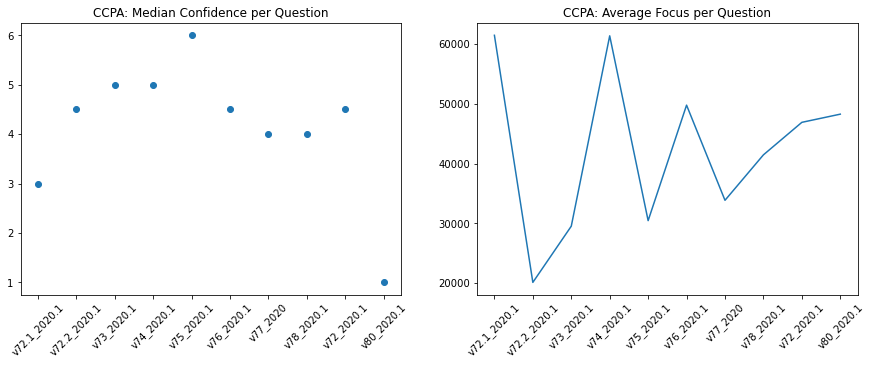

In [61]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

ax.set_xticklabels(CCPA_df['question_id'], rotation = 45)
ax2.set_xticklabels(CCPA_df['question_id'], rotation = 45)

ax.scatter(CCPA_df['question_id'], CCPA_df['median_confidence'])
ax.title.set_text('CCPA: Median Confidence per Question')
ax2.plot(CCPA_df['question_id'], CCPA_df['average_focus'])
ax2.title.set_text('CCPA: Average Focus per Question')